## Linear Regression for molecules solubility

#### Read data

In [15]:
import pandas as pd
import numpy as np


# Reading csv
sol_df = pd.read_csv("data/delaney-processed.csv")
sol_df.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


#### Show a molecule for fun

In [16]:
from src.utils import show_molecule_from_smiles

molecule = sol_df.iloc[10]
print(f"Name: {molecule["Compound ID"]}")
print(f"Smiles: {molecule["smiles"]}")
show_molecule_from_smiles(molecule["smiles"])

Name: 2-pyrrolidone
Smiles: O=C1CCCN1


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

🧪 **Element Colors (CPK Convention)**

- 🟤 Carbon (C) – Grey/Black
- 🔵 Nitrogen (N) – Blue
- 🔴 Oxygen (O) – Red
- 🟡 Sulfur (S) – Yellow
- 🟢 Chlorine (Cl) – Green
- ⚪ Hydrogen (H) – White
- 🟠 Phosphorus (P) – Orange

#### Trying basic Linear Regression (no scaling)

R^2: 0.6961
RMSE: 1.1986


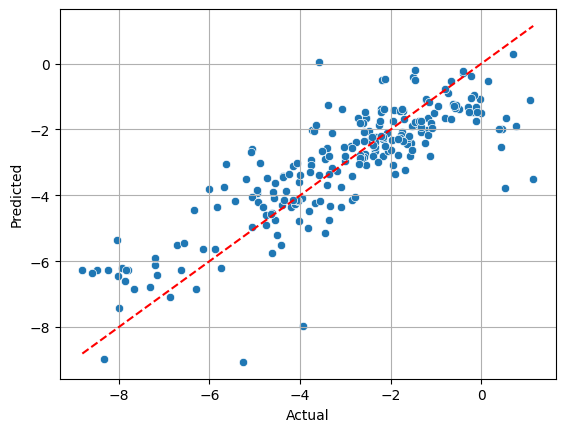

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from src.utils import show_accuracy


rel_features = [
    "Molecular Weight",
    "Minimum Degree",
    "Number of H-Bond Donors",
    "Number of Rings",
    "Number of Rotatable Bonds",
    "Polar Surface Area",
]
target = "measured log solubility in mols per litre"

# Train-test splitting
X = sol_df[rel_features]
y = sol_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate model
model = LinearRegression()
# Train the model
model.fit(X_train, y_train)
# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate
show_accuracy(y_test=y_test, y_pred=y_pred)

#### Trying Linear Regression with scaling

R^2: 0.6961
RMSE: 1.1986


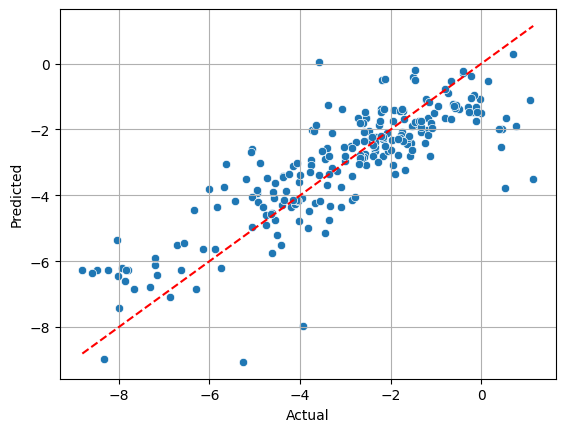

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from src.utils import show_accuracy


rel_features = [
    "Molecular Weight",
    "Minimum Degree",
    "Number of H-Bond Donors",
    "Number of Rings",
    "Number of Rotatable Bonds",
    "Polar Surface Area",
]
target = "measured log solubility in mols per litre"

# Train-test splitting
X = sol_df[rel_features]
y = sol_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Instantiate model
model = LinearRegression()
# Train the model
model.fit(X_train_scaled, y_train)
# Make predictions on the testing data
y_pred = model.predict(X_test_scaled)

# Evaluate
show_accuracy(y_test=y_test, y_pred=y_pred)

#### Trying Linear Regression scaled with feature engineering

R^2: 0.7774
RMSE: 1.0256


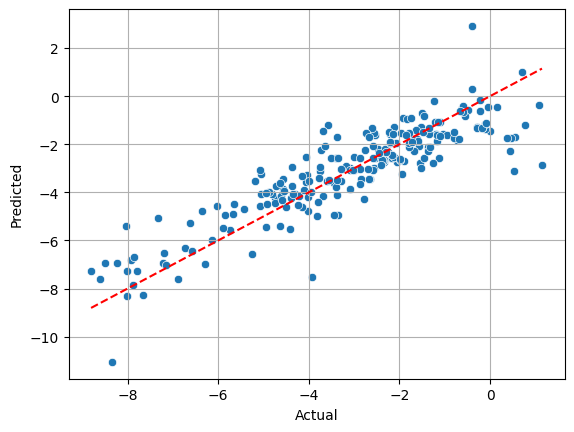

In [19]:
from rdkit.Chem import Descriptors
from rdkit import Chem

# First create the molecule object for each entry
sol_df["rdkit_mol"] = sol_df["smiles"].apply(Chem.MolFromSmiles)

# Then use that to extract other features with RDkit
sol_df["MolLogP"] = sol_df["rdkit_mol"].apply(Descriptors.MolLogP)
sol_df["MolMR"] = sol_df["rdkit_mol"].apply(Descriptors.MolMR)
sol_df["HeavyAtomCount"] = sol_df["rdkit_mol"].apply(Descriptors.HeavyAtomCount)
sol_df["FractionCSP3"] = sol_df["rdkit_mol"].apply(Descriptors.FractionCSP3)
sol_df["TPSA"] = sol_df["rdkit_mol"].apply(Descriptors.TPSA)
sol_df["NumAromaticRings"] = sol_df["rdkit_mol"].apply(Descriptors.NumAromaticRings)
sol_df["NumHDonors"] = sol_df["rdkit_mol"].apply(Descriptors.NumHDonors)
sol_df["NumHAcceptors"] = sol_df["rdkit_mol"].apply(Descriptors.NumHAcceptors)

rel_features = [
    "Molecular Weight",
    "Minimum Degree",
    "Number of H-Bond Donors",
    "Number of Rings",
    "Number of Rotatable Bonds",
    "Polar Surface Area",
    "MolLogP",
    "MolMR",
    "HeavyAtomCount",
    "FractionCSP3",
    "TPSA",
    "NumAromaticRings",
    "NumHDonors",
    "NumHAcceptors",
]
target = "measured log solubility in mols per litre"

# Train-test splitting
X = sol_df[rel_features]
y = sol_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Instantiate model
model = LinearRegression()
# Train the model
model.fit(X_train_scaled, y_train)
# Make predictions on the testing data
y_pred = model.predict(X_test_scaled)

# Evaluate
show_accuracy(y_test=y_test, y_pred=y_pred)